# SERIES DE TIEMPO MULTIVARIADAS PARA PRONOSTICAR EL NÚMERO DE SUICIDIOS POR CADA 100 MIL HABITANTES EN PAÍSES DE LATINOAMÉRICA Y ESPAÑA.






## Carga de ibrerias

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from tensorflow import keras as ks
from keras.layers import GRU

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0


Using TensorFlow backend.


In [4]:
from tensorflow.estimator import LinearRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

## Carga de base de datos

In [5]:
#suicides_load=pd.read_csv('C:/Users/Viviana/Desktop/Materias/Mineria/master.csv')
suicides_load=pd.read_csv('/content/master1.csv')

## Variables dummy

In [6]:
dummie_sex=pd.get_dummies(suicides_load.sex)
dummie_age=pd.get_dummies(suicides_load.age)
#dummie_generation=pd.get_dummies(suicides_load.generation)

## Columnas de la base original junto con las columnas de las variables dummy

In [7]:
#suicides_data=pd.concat([suicides_load,dummie_sex,dummie_age,dummie_generation],axis='columns')
suicides_data=pd.concat([suicides_load,dummie_sex,dummie_age],axis='columns')
#suicides_data=suicides_data.drop(['sex','age','generation','HDI for year'],axis='columns')
suicides_data=suicides_data.drop(['sex','age','generation','HDI for year','gdp_for_year',],axis='columns')
suicides_data.head(3)

,country,year,suicides_no,population,suicides/100k pop,country-year,gdp_per_capita,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
0,Albania,1987,21,312900.0,6.71,Albania1987,796,0,1,1,0,0,0,0,0
1,Albania,1987,16,308000.0,5.19,Albania1987,796,0,1,0,0,1,0,0,0
2,Albania,1987,14,289700.0,4.83,Albania1987,796,1,0,1,0,0,0,0,0


**GDP:** Son las siglas en inglés (Gross Domestic Product) del Producto Interno Bruto o PIB que describe el valor monetario de la producción de servicios y bienes de demanda final en un país, en este caso, **anualmente**.

**GDP Per Capita:** Es la división del Producto Interno Bruto de cada país dividido entre el número total de habitantes.

Se usan para mostrar las diferencias económicas entre países.


## Arreglo de la base de datos

In [8]:
suicides_dummys=suicides_data.iloc[:,7:16].mul(suicides_data['suicides_no'], axis=0)
suicides_data2=pd.concat([suicides_data.iloc[:,0:7],suicides_dummys], axis='columns')
data=suicides_data2.groupby(['country','year','country-year', 'gdp_per_capita']).sum()
data['suicides/100k pop']=100000*(data['suicides_no']/data['population'])
data=data.reset_index()
data=data.set_index('year')
data=data.drop(['country-year'],axis='columns')
data.head(5)

,country,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,,
1987,Albania,796,73,2709600.0,2.694125,25,48,35,13,22,0,1,2
1988,Albania,769,63,2764300.0,2.279058,22,41,25,10,18,0,7,3
1989,Albania,833,68,2803100.0,2.425886,15,53,17,20,22,0,7,2
1992,Albania,251,47,2822500.0,1.665190,14,33,16,11,14,0,6,0
1993,Albania,437,73,2807300.0,2.600363,27,46,28,16,17,2,9,1


# Guatemala


In [955]:
Guatemala_suicides=data[data.country=="Guatemala"]
Guatemala_suicides=Guatemala_suicides.drop(['country'],axis='columns')
Guatemala_suicides.shape
Guatemala_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,1044,203,6924188.0,2.931752,36,167,82,54,41,4,19,3
1987,997,241,7108740.0,3.390193,57,184,66,79,62,8,19,7


# Gráfico de serie de interes (suicides/100k pop) y de coseries

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


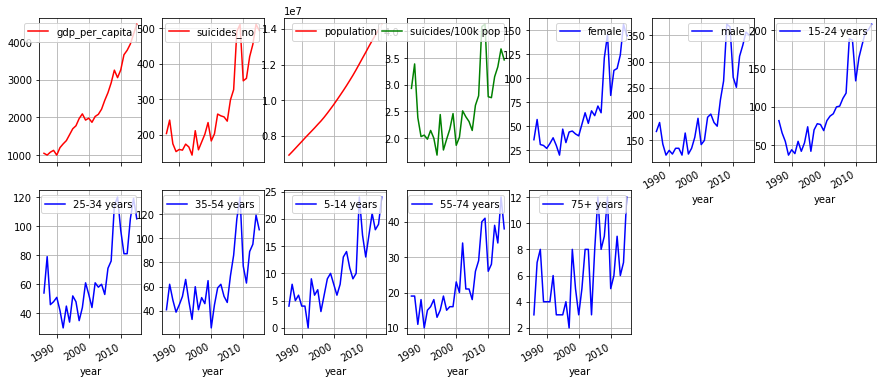

In [956]:
features=Guatemala_suicides
features.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]

plt.show()

## Selección de tamaño de muestra de entrenamiento y validación


In [1047]:
train_set=features.iloc[:25, :]
#train_set.shape
test_set=features.iloc[25:30,:]
test_set.shape
#train_set.shape[0]

(5, 12)

## Estandarización de datos

In [1048]:
TRAIN_SPLIT=train_set.shape[0]
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

## Función Ventana de entrenamiento.

In [19]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

## Selección de muestra de entrenamiento y validación para modelo multivariado

In [1049]:
past_history = 4 #se usan los últimos 5 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 3], 0,  #la columna 4 es 'suicides/100k pop'
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 3],
                                               TRAIN_SPLIT, 30, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [967]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (4, 12)


## Convertir datos en tensores

In [1050]:
BATCH_SIZE=2 # 2 Lotes de 13 y 12 filas o registros 
BUFFER_SIZE=1000
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [962]:
train_data_single
val_data_single

<RepeatDataset shapes: ((None, 4, 12), (None,)), types: (tf.float64, tf.float64)>

## MODELO DE RED LSTM

In [1051]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(70,input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model.summary()

Model: "sequential_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_129 (LSTM)              (None, 70)                23240     
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 71        
Total params: 23,311
Trainable params: 23,311
Non-trainable params: 0
_________________________________________________________________


In [ ]:
val_data_single
train_data_single

<RepeatDataset shapes: ((None, 4, 12), (None,)), types: (tf.float64, tf.float64)>

## Evaluación de función de pérdida

In [1052]:
EPOCHS=20
EVALUATION_INTERVAL=1
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=1)

Epoch 1/20
1/1 [==============================] - 0s 349ms/step - loss: 0.7411 - val_loss: 1.6799
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 0.3433 - val_loss: 1.8293
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 0.4846 - val_loss: 1.1826
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 1.1836 - val_loss: 0.7940
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 1.3278 - val_loss: 0.5451
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 0.4776 - val_loss: 0.4662
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 0.2121 - val_loss: 0.3467
Epoch 8/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1742 - val_loss: 0.3628
Epoch 9/20
1/1 [==============================] - 0s 8ms/step - loss: 0.3698 - val_loss: 0.4133
Epoch 10/20
1/1 [==============================] - 0s 6ms/step - loss: 0.5863 - val_loss: 0.4077
Epoch 11/20
1/1 [====================

## Función para gráficar pérdida

In [20]:
#### FUNCIÓN PARA GRAFICAR EL ENTRENAMIENTO DE UN PASO Y FUNCIÓN DE PÉRDIDA
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

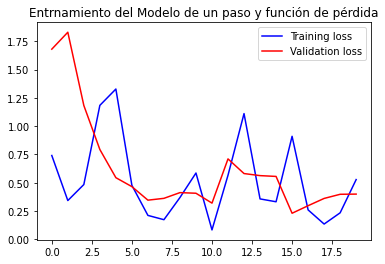

In [1053]:
plot_train_history(single_step_history,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

In [21]:
def create_time_steps(length):
  return list(range(-length, 0))

In [22]:
#### FUNCIÓN PARA GRAFICAR DATOS HISTÓRICOS Y PREDICCIÓN
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

# PREDICCIÓN A UN PASO 

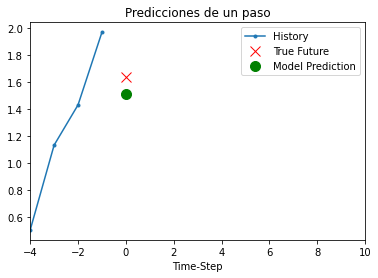

In [ ]:
for x, y in val_data_single.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 0,
                   'Predicciones de un paso')
  plot.show()

## Graficar serie con dato predicho

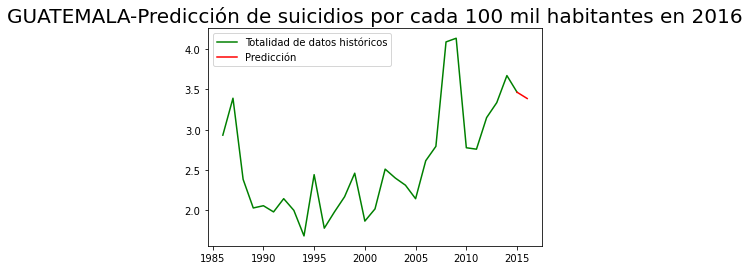

In [ ]:
N=len(Guatemala_suicides.index)-1
new_index=np.append(Guatemala_suicides.index, Guatemala_suicides.index[N]+1)
new_pred=single_step_model.predict(x)[0]*data_std[3]+data_mean[3]
new_suicides_rate=np.append(Guatemala_suicides['suicides/100k pop'],new_pred)
new_data=pd.DataFrame({'new_suicides_rate':new_suicides_rate},index=new_index)
plt.plot(new_data[:N+1], color='g', label='Totalidad de datos históricos')
plt.plot(new_data[N:],label='Predicción',color='r')
plt.title("GUATEMALA-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()

# BRASIL

In [1054]:
brazil_suicides=data[data.country=="Brazil"]
brazil_suicides=brazil_suicides.drop(['country'],axis='columns')
brazil_suicides=brazil_suicides.drop([1985],axis=0)
brazil_suicides.shape
brazil_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,2257,4271,118776400.0,3.595832,1154,3117,1016,1011,1302,62,744,136
1987,2394,4672,122822467.0,3.803864,1163,3509,1004,1131,1449,67,844,177


## Gráfico de serie de interes (suicides/100k pop) y de coseries

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


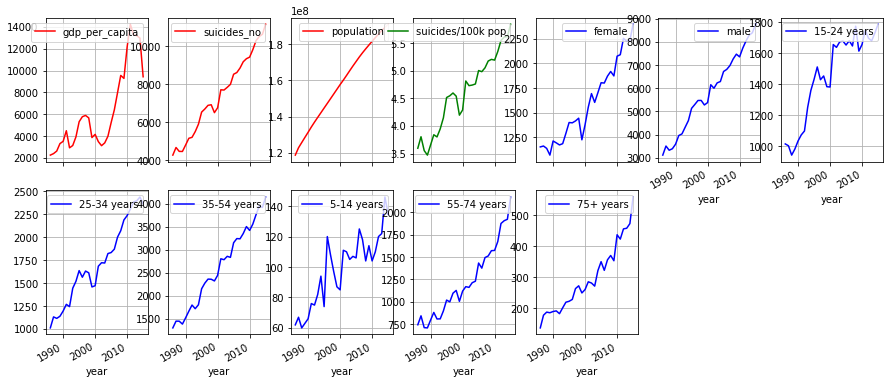

In [1055]:
featuresB=brazil_suicides
featuresB.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

## Selección de tamaño de muestra de entrenamiento y validación

In [1057]:
featuresB=brazil_suicides
train_setB=featuresB.iloc[:25, :]
test_setB=featuresB.iloc[25:30,:]
test_setB.shape

(5, 12)

## Estandarización de datos

In [1058]:
TRAIN_SPLITB=train_setB.shape[0]
datasetB = featuresB.values
data_meanB = datasetB[:TRAIN_SPLITB].mean(axis=0)
data_stdB = datasetB[:TRAIN_SPLITB].std(axis=0)
datasetB = (datasetB-data_meanB)/data_stdB

# Selección de ventana de entrenamiento y validación para modelo multivariado

In [1059]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleB, y_train_singleB = multivariate_data(datasetB, datasetB[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITB, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleB, y_val_singleB = multivariate_data(datasetB, datasetB[:, 3],
                                               TRAIN_SPLITB, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

## Convertir datos en tensores

In [1060]:
BATCH_SIZE=2 
BUFFER_SIZE=1000

train_data_singleB = tf.data.Dataset.from_tensor_slices((x_train_singleB, y_train_singleB))
train_data_singleB = train_data_singleB.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleB = tf.data.Dataset.from_tensor_slices((x_val_singleB, y_val_singleB))
val_data_singleB = val_data_singleB.batch(BATCH_SIZE).repeat()

## MODELO DE RED LSTM

In [1062]:
single_step_modelB = tf.keras.models.Sequential()
single_step_modelB.add(tf.keras.layers.LSTM(60,input_shape=x_train_singleB.shape[-2:]))
#single_step_modelB.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,input_shape=x_train_singleB.shape[-2:])))
single_step_modelB.add(tf.keras.layers.Dense(1))
single_step_modelB.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_modelB.summary()

Model: "sequential_130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_130 (LSTM)              (None, 60)                17520     
_________________________________________________________________
dense_130 (Dense)            (None, 1)                 61        
Total params: 17,581
Trainable params: 17,581
Non-trainable params: 0
_________________________________________________________________


## Evaluación de función de pérdida

In [ ]:
EPOCHS=30
EVALUATION_INTERVAL=1
single_step_historyB = single_step_modelB.fit(train_data_singleB, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleB,
                                            validation_steps=1)

Epoch 1/30
1/1 [==============================] - 0s 411ms/step - loss: 0.3802 - val_loss: 2.9512
Epoch 2/30
1/1 [==============================] - 0s 11ms/step - loss: 0.3356 - val_loss: 2.9926
Epoch 3/30
1/1 [==============================] - 0s 12ms/step - loss: 1.5328 - val_loss: 2.5923
Epoch 4/30
1/1 [==============================] - 0s 21ms/step - loss: 0.9381 - val_loss: 2.5263
Epoch 5/30
1/1 [==============================] - 0s 11ms/step - loss: 0.4057 - val_loss: 2.4663
Epoch 6/30
1/1 [==============================] - 0s 13ms/step - loss: 0.9967 - val_loss: 2.1472
Epoch 7/30
1/1 [==============================] - 0s 10ms/step - loss: 0.4158 - val_loss: 2.0124
Epoch 8/30
1/1 [==============================] - 0s 11ms/step - loss: 0.7583 - val_loss: 1.7495
Epoch 9/30
1/1 [==============================] - 0s 12ms/step - loss: 0.5482 - val_loss: 1.4903
Epoch 10/30
1/1 [==============================] - 0s 12ms/step - loss: 0.1839 - val_loss: 1.3968
Epoch 11/30
1/1 [===========

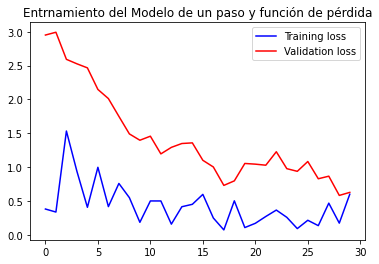

In [ ]:
plot_train_history(single_step_historyB,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

## Obtención de la predicción a un paso

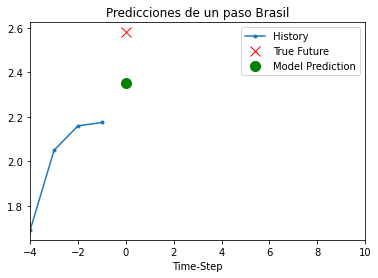

In [ ]:
for x, y in val_data_singleB.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelB.predict(x)[0]], 0,
                   'Predicciones de un paso Brasil')
  plot.show()

## Graficar serie con dato predicho

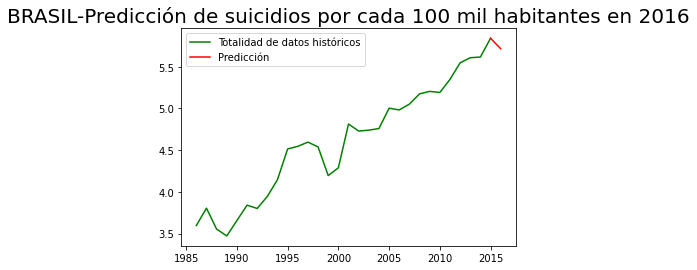

In [ ]:
N=len(brazil_suicides.index)-1
new_index=np.append(brazil_suicides.index, brazil_suicides.index[N]+1)
new_pred=(single_step_modelB.predict(x)[0])*data_stdB[3]+data_meanB[3]
new_suicides_rate=np.append(brazil_suicides['suicides/100k pop'],new_pred)
new_data=pd.DataFrame({'new_suicides_rate':new_suicides_rate},index=new_index)
plt.plot(new_data[:N+1], color='g', label='Totalidad de datos históricos')
plt.plot(new_data[N:],label='Predicción',color='r')
plt.title("BRASIL-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()

## MODELO DE RED GRU

In [1065]:
model_gru = tf.keras.models.Sequential()
model_gru.add(tf.keras.layers.GRU(60,input_shape=x_train_singleB.shape[-2:]))
model_gru.add(tf.keras.layers.Dense(1))
model_gru.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
model_gru.summary()

Model: "sequential_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 60)                13320     
_________________________________________________________________
dense_132 (Dense)            (None, 1)                 61        
Total params: 13,381
Trainable params: 13,381
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS=30
EVALUATION_INTERVAL=1
single_step_historyBgru = model_gru.fit(train_data_singleB, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleB,
                                        validation_steps=1)

Epoch 1/30
1/1 [==============================] - 0s 392ms/step - loss: 1.0835 - val_loss: 2.2823
Epoch 2/30
1/1 [==============================] - 0s 16ms/step - loss: 1.0806 - val_loss: 1.6755
Epoch 3/30
1/1 [==============================] - 0s 14ms/step - loss: 0.7260 - val_loss: 1.1485
Epoch 4/30
1/1 [==============================] - 0s 14ms/step - loss: 0.3335 - val_loss: 1.1413
Epoch 5/30
1/1 [==============================] - 0s 13ms/step - loss: 0.3640 - val_loss: 0.9960
Epoch 6/30
1/1 [==============================] - 0s 13ms/step - loss: 0.1861 - val_loss: 0.9736
Epoch 7/30
1/1 [==============================] - 0s 11ms/step - loss: 0.5543 - val_loss: 1.0388
Epoch 8/30
1/1 [==============================] - 0s 11ms/step - loss: 0.5165 - val_loss: 1.1553
Epoch 9/30
1/1 [==============================] - 0s 11ms/step - loss: 0.5961 - val_loss: 1.3557
Epoch 10/30
1/1 [==============================] - 0s 14ms/step - loss: 0.4768 - val_loss: 0.7643
Epoch 11/30
1/1 [===========

## Evaluación función de pérdida con Red GRU

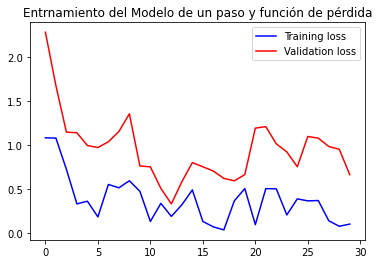

In [ ]:
plot_train_history(single_step_historyBgru,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

## Predicción a un paso con modelo GRU

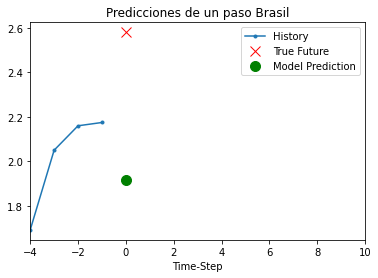

In [ ]:
for x, y in val_data_singleB.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    model_gru.predict(x)[0]], 0,
                   'Predicciones de un paso Brasil')
  plot.show()

Dado que se tuvieron mejores resultados con la modelo LSTM unidireccional, se seguirá trabajando con este.

#CHILE

In [ ]:
chile_suicides=data[data.country=="Chile"]
chile_suicides=chile_suicides.drop(['country'],axis='columns')
chile_suicides=chile_suicides.drop([1985],axis=0)
chile_suicides.shape
chile_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,1728,654,10931700.0,5.982601,122,532,145,150,193,11,131,24
1987,1985,693,11209000.0,6.182532,125,568,154,176,194,7,143,19


## Gráfico de serie de estudio (suicides/100k pop) y de coseries

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


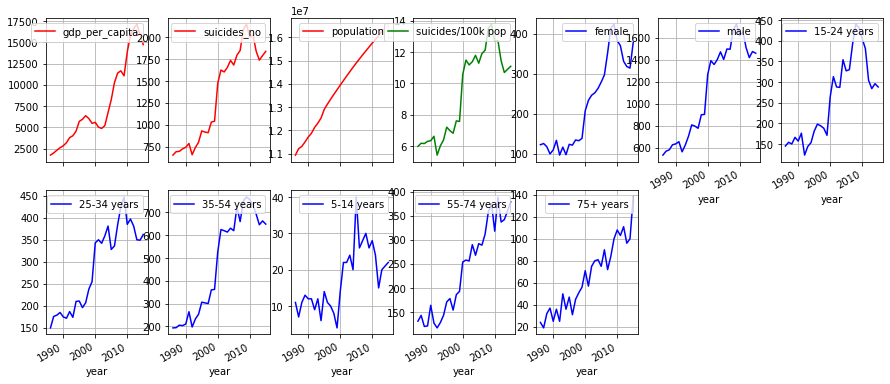

In [ ]:
featuresCH=chile_suicides
featuresCH.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

## Selección de tamaño de muestra de entrenamiento y validación

In [ ]:
featuresCH=chile_suicides
train_setCH=featuresCH.iloc[:25, :]
test_setCH=featuresCH.iloc[25:30,:]
test_setCH.shape

(5, 12)

## Estandarización de datos

In [ ]:
TRAIN_SPLITCH=train_setCH.shape[0]
datasetCH = featuresCH.values
data_meanCH = datasetCH[:TRAIN_SPLITCH].mean(axis=0)
data_stdCH = datasetCH[:TRAIN_SPLITCH].std(axis=0)
datasetCH = (datasetCH-data_meanCH)/data_stdCH

## Selección de ventana de entrenamiento y validación para modelo multivariado

In [ ]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleCH, y_train_singleCH = multivariate_data(datasetCH, datasetCH[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITCH, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleCH, y_val_singleCH = multivariate_data(datasetCH, datasetCH[:, 3],
                                               TRAIN_SPLITCH, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

## Convertir datos en tensores

In [ ]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_singleCH = tf.data.Dataset.from_tensor_slices((x_train_singleCH, y_train_singleCH))
train_data_singleCH = train_data_singleCH.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleCH = tf.data.Dataset.from_tensor_slices((x_val_singleCH, y_val_singleCH))
val_data_singleCH = val_data_singleCH.batch(BATCH_SIZE).repeat()

## MODELO DE RED LSTM

In [ ]:
single_step_modelCH = tf.keras.models.Sequential()
single_step_modelCH.add(tf.keras.layers.LSTM(60,input_shape=x_train_singleCH.shape[-2:]))
single_step_modelCH.add(tf.keras.layers.Dense(1))
single_step_modelCH.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

## Evaluación de función de pérdida

In [ ]:
EPOCHS=30
EVALUATION_INTERVAL=1
single_step_historyCH = single_step_modelCH.fit(train_data_singleCH, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleCH,
                                            validation_steps=1)

Epoch 1/30
1/1 [==============================] - 0s 442ms/step - loss: 1.7240 - val_loss: 1.0579
Epoch 2/30
1/1 [==============================] - 0s 15ms/step - loss: 0.8911 - val_loss: 0.9765
Epoch 3/30
1/1 [==============================] - 0s 12ms/step - loss: 0.4920 - val_loss: 0.8839
Epoch 4/30
1/1 [==============================] - 0s 12ms/step - loss: 0.6565 - val_loss: 0.8691
Epoch 5/30
1/1 [==============================] - 0s 12ms/step - loss: 0.1887 - val_loss: 0.8258
Epoch 6/30
1/1 [==============================] - 0s 13ms/step - loss: 1.2532 - val_loss: 0.6999
Epoch 7/30
1/1 [==============================] - 0s 14ms/step - loss: 0.2440 - val_loss: 0.7025
Epoch 8/30
1/1 [==============================] - 0s 13ms/step - loss: 0.4237 - val_loss: 0.7246
Epoch 9/30
1/1 [==============================] - 0s 12ms/step - loss: 0.3066 - val_loss: 0.6586
Epoch 10/30
1/1 [==============================] - 0s 12ms/step - loss: 0.8599 - val_loss: 0.4068
Epoch 11/30
1/1 [===========

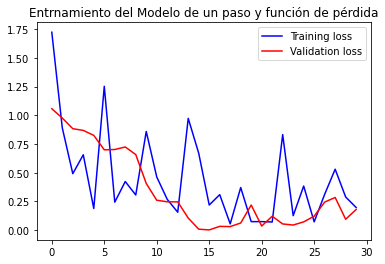

In [ ]:
plot_train_history(single_step_historyCH,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

## Obtención de la predicción a un paso

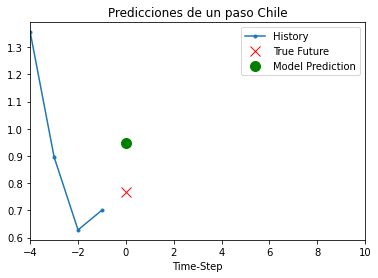

In [ ]:

for x, y in val_data_singleCH.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelCH.predict(x)[0]], 0,
                   'Predicciones de un paso Chile')
  plot.show()

## Graficar serie con dato predicho

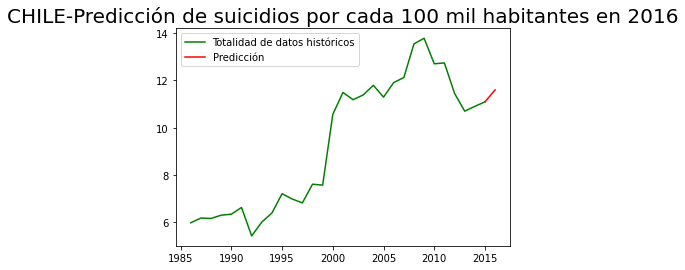

In [ ]:
N=len(chile_suicides.index)-1
new_index=np.append(chile_suicides.index, chile_suicides.index[N]+1)
new_pred=(single_step_modelCH.predict(x)[0])*data_stdCH[3]+data_meanCH[3]
new_suicides_rate=np.append(chile_suicides['suicides/100k pop'],new_pred)
new_data=pd.DataFrame({'new_suicides_rate':new_suicides_rate},index=new_index)
plt.plot(new_data[:N+1], color='g', label='Totalidad de datos históricos')
plt.plot(new_data[N:],label='Predicción',color='r')
plt.title("CHILE-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()

# ECUADOR

In [ ]:
ecuador_suicides=data[data.country=="Ecuador"]
ecuador_suicides=ecuador_suicides.drop(['country'],axis='columns')
ecuador_suicides=ecuador_suicides.drop([1985],axis=0)
#ecuador_suicides.shape
ecuador_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,1943,377,7881300.0,4.783475,131,246,161,95,64,12,35,10
1987,1669,390,8356800.0,4.666858,131,259,157,100,89,12,25,7


## Gráfico de serie de interes (suicides/100k pop) y de coseries

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


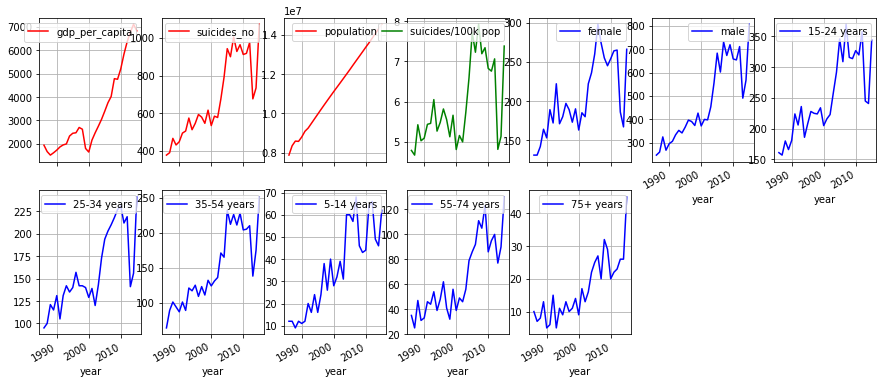

In [ ]:
featuresEC=ecuador_suicides
featuresEC.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

## Selección de tamaño de muestra de entrenamiento y validación

In [ ]:
featuresEC=ecuador_suicides
train_setEC=featuresEC.iloc[:25, :]
test_setEC=featuresEC.iloc[25:30,:]
test_setEC.shape

(5, 12)

## Estandarización de datos

In [ ]:
TRAIN_SPLITEC=train_setEC.shape[0]
datasetEC = featuresEC.values
data_meanEC = datasetEC[:TRAIN_SPLITEC].mean(axis=0)
data_stdEC = datasetEC[:TRAIN_SPLITEC].std(axis=0)
datasetEC = (datasetEC-data_meanEC)/data_stdEC


## Selección de muestra de entrenamiento y validación para modelo multivariado

In [ ]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleEC, y_train_singleEC = multivariate_data(datasetEC, datasetEC[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITEC, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleEC, y_val_singleEC = multivariate_data(datasetEC, datasetEC[:, 3],
                                               TRAIN_SPLITEC, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

## Convertir datos en tensores

In [ ]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_singleEC = tf.data.Dataset.from_tensor_slices((x_train_singleEC, y_train_singleEC))
train_data_singleEC = train_data_singleEC.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleEC = tf.data.Dataset.from_tensor_slices((x_val_singleEC, y_val_singleEC))
val_data_singleEC = val_data_singleEC.batch(BATCH_SIZE).repeat()

## MODELO DE RED LSTM

In [ ]:
single_step_modelEC = tf.keras.models.Sequential()
single_step_modelEC.add(tf.keras.layers.LSTM(60,input_shape=x_train_singleEC.shape[-2:]))
single_step_modelEC.add(tf.keras.layers.Dense(1))
single_step_modelEC.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

## Evaluación de función de pérdida

In [ ]:
EPOCHS=30
EVALUATION_INTERVAL=1
single_step_historyEC = single_step_modelEC.fit(train_data_singleEC, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleEC,
                                            validation_steps=1)

Epoch 1/30
1/1 [==============================] - 0s 403ms/step - loss: 0.6736 - val_loss: 1.2106
Epoch 2/30
1/1 [==============================] - 0s 8ms/step - loss: 1.0366 - val_loss: 1.0530
Epoch 3/30
1/1 [==============================] - 0s 12ms/step - loss: 0.6990 - val_loss: 0.9488
Epoch 4/30
1/1 [==============================] - 0s 8ms/step - loss: 0.7160 - val_loss: 0.9288
Epoch 5/30
1/1 [==============================] - 0s 7ms/step - loss: 0.5441 - val_loss: 0.8454
Epoch 6/30
1/1 [==============================] - 0s 8ms/step - loss: 0.9992 - val_loss: 0.6351
Epoch 7/30
1/1 [==============================] - 0s 8ms/step - loss: 0.3590 - val_loss: 0.6688
Epoch 8/30
1/1 [==============================] - 0s 8ms/step - loss: 0.8299 - val_loss: 0.6320
Epoch 9/30
1/1 [==============================] - 0s 7ms/step - loss: 0.3712 - val_loss: 0.6763
Epoch 10/30
1/1 [==============================] - 0s 7ms/step - loss: 0.0195 - val_loss: 0.6419
Epoch 11/30
1/1 [===================

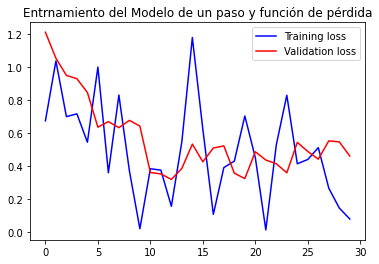

In [ ]:
plot_train_history(single_step_historyEC,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

## Obtención de la predicción a un paso

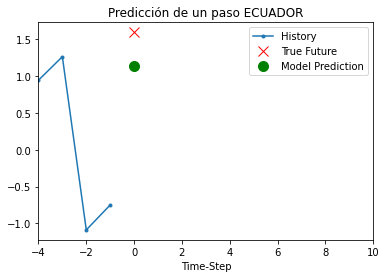

In [ ]:
for x, y in val_data_singleEC.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelEC.predict(x)[0]], 0,
                   'Predicción de un paso ECUADOR')
  plot.show()


## Graficar serie con dato predicho

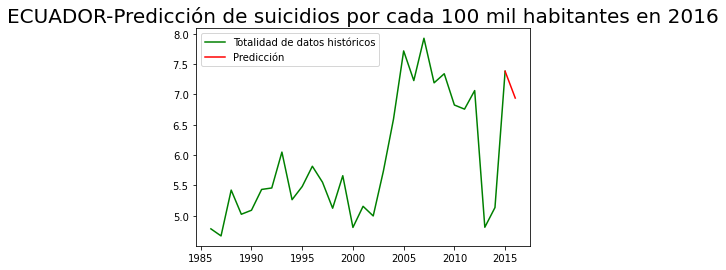

In [ ]:
N=len(ecuador_suicides.index)-1
new_index=np.append(ecuador_suicides.index, ecuador_suicides.index[N]+1)
new_pred=(single_step_modelEC.predict(x)[0])*data_stdEC[3]+data_meanEC[3]
new_suicides_rate=np.append(ecuador_suicides['suicides/100k pop'],new_pred)
new_data=pd.DataFrame({'new_suicides_rate':new_suicides_rate},index=new_index)
plt.plot(new_data[:N+1], color='g', label='Totalidad de datos históricos')
plt.plot(new_data[N:],label='Predicción',color='r')
plt.title("ECUADOR-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()

# COSTA RICA

Costa rica tiene registros desde el año 1985 al 2014. Todos los países trabajados hasta ahora se han dejado con registros desde 1986 a 2015 y se realiza la predicción de 2016.
Por esta razón se hará predicción multipaso para los años 2015 y 2016 para Costa Rica y finalmente hacer un recorte del año 1985 para que tenga el mismo tamaño de las series de los demás países.

In [ ]:
costar_suicides=data[data.country=="Costa Rica"]
costar_suicides=costar_suicides.drop(['country'],axis='columns')
#costar_suicides=costar_suicides.drop([1985],axis=0)
costar_suicides.shape
costar_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1985,2145,128,2236200.0,5.723996,16,112,41,35,35,3,13,1
1986,2389,131,2292900.0,5.713289,13,118,27,28,50,2,21,3


## Gráfico de serie de interes (suicides/100k pop) y de coseries

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


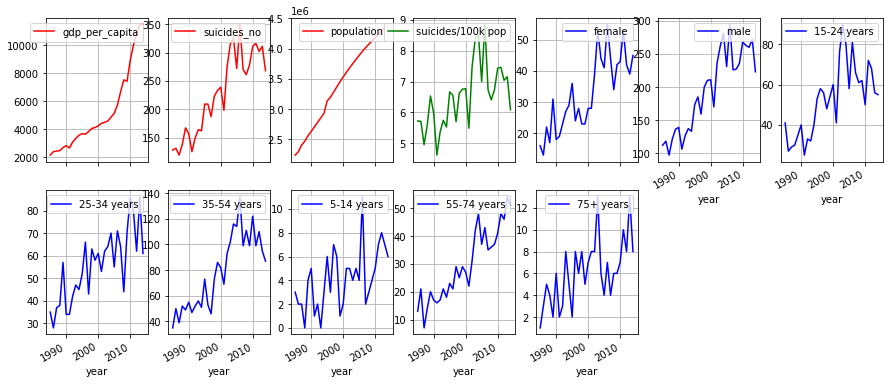

In [ ]:
featuresCR=costar_suicides
featuresCR.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

## Selección de tamaño de muestra de entrenamiento y validación

In [ ]:
featuresCR=costar_suicides
train_setCR=featuresCR.iloc[:24, :]
test_setCR=featuresCR.iloc[24:30,:]
test_setCR.shape

(6, 12)

## Estandarización de datos

In [ ]:
TRAIN_SPLITCR=train_setCR.shape[0]
datasetCR = featuresCR.values
data_meanCR = datasetCR[:TRAIN_SPLITCR].mean(axis=0)
data_stdCR = datasetCR[:TRAIN_SPLITCR].std(axis=0)
datasetCR = (datasetCR-data_meanCR)/data_stdCR

## Selección de muestra de entrenamiento y validación para modelo **multipaso** multivariado

In [ ]:
past_history = 3
future_target = 2 # Se requiere predicción de dos años: 2015 y 2016.
STEP=1
x_train_multiCR, y_train_multiCR = multivariate_data(datasetCR, datasetCR[:, 3], 0,
                                                 TRAIN_SPLITCR, past_history,
                                                 future_target, STEP)
x_val_multiCR, y_val_multiCR = multivariate_data(datasetCR, datasetCR[:, 3],
                                             TRAIN_SPLITCR, None, past_history,
                                             future_target, STEP)

In [ ]:
print ('Single window of past history : {}'.format(x_train_multiCR[0].shape))
print ('\n Target suicides for 100kp to predict : {}'.format(y_train_multiCR[0].shape))

Single window of past history : (3, 12)

 Target suicides for 100kp to predict : (2,)


## Convertir datos en tensores

In [ ]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_multiCR = tf.data.Dataset.from_tensor_slices((x_train_multiCR, y_train_multiCR))
train_data_multiCR = train_data_multiCR.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multiCR = tf.data.Dataset.from_tensor_slices((x_val_multiCR, y_val_multiCR))
val_data_multiCR = val_data_multiCR.batch(BATCH_SIZE).repeat()

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

## Función para ventana Multipaso

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

## Dos últimos años que se quieren predecir para comprobar eficiencia del modelo

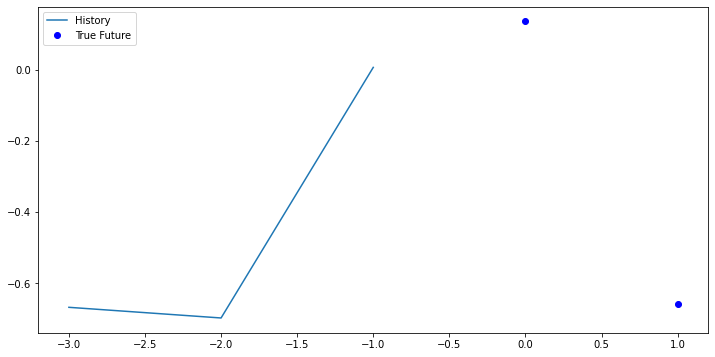

In [ ]:
for x, y in train_data_multiCR.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

## MODELO DE RED LSTM MULTIPASO

In [ ]:
multi_step_modelCR = tf.keras.models.Sequential()
multi_step_modelCR.add(tf.keras.layers.LSTM(60,
                                          return_sequences=True,
                                          input_shape=x_train_multiCR.shape[-2:]))
multi_step_modelCR.add(tf.keras.layers.LSTM(30, activation='relu'))
multi_step_modelCR.add(tf.keras.layers.Dense(2))

multi_step_modelCR.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

## Evaluación de función de pérdida

In [ ]:
EPOCHS=100
multi_step_historyCR = multi_step_modelCR.fit(train_data_multiCR, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multiCR,
                                          validation_steps=1)

Epoch 1/100
1/1 [==============================] - 0s 463ms/step - loss: 0.5985 - val_loss: 0.6675
Epoch 2/100
1/1 [==============================] - 0s 10ms/step - loss: 1.0510 - val_loss: 0.6575
Epoch 3/100
1/1 [==============================] - 0s 9ms/step - loss: 0.4281 - val_loss: 0.6594
Epoch 4/100
1/1 [==============================] - 0s 10ms/step - loss: 0.9312 - val_loss: 0.6226
Epoch 5/100
1/1 [==============================] - 0s 9ms/step - loss: 0.7736 - val_loss: 0.5628
Epoch 6/100
1/1 [==============================] - 0s 10ms/step - loss: 0.6960 - val_loss: 0.5647
Epoch 7/100
1/1 [==============================] - 0s 9ms/step - loss: 0.9559 - val_loss: 0.5641
Epoch 8/100
1/1 [==============================] - 0s 10ms/step - loss: 1.1675 - val_loss: 0.5419
Epoch 9/100
1/1 [==============================] - 0s 9ms/step - loss: 0.7244 - val_loss: 0.5089
Epoch 10/100
1/1 [==============================] - 0s 10ms/step - loss: 0.3158 - val_loss: 0.5091
Epoch 11/100
1/1 [====

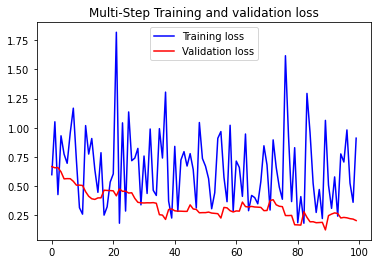

In [ ]:
plot_train_history(multi_step_historyCR, 'Multi-Step Training and validation loss')

## Obtención de predicción a dos pasos

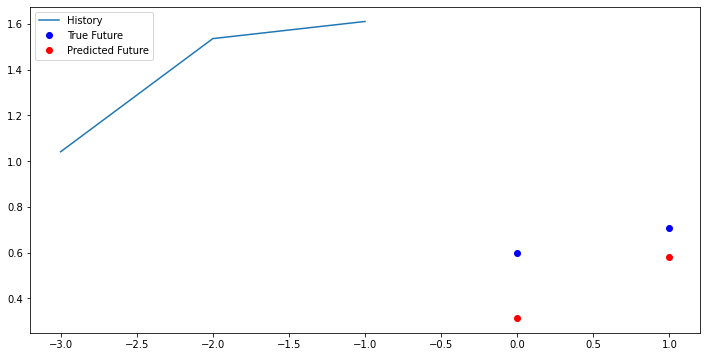

In [ ]:
for x, y in val_data_multiCR.take(1):
  multi_step_plot(x[0], y[0], multi_step_modelCR.predict(x)[0])

## Graficar serie con dato predicho

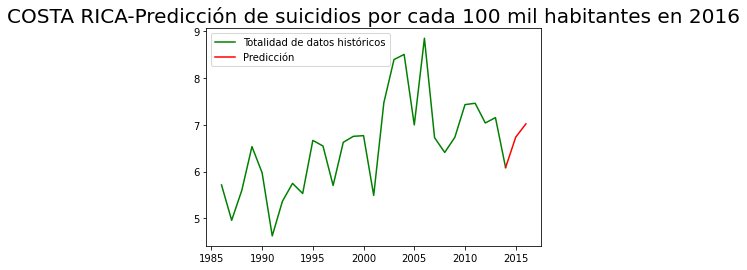

In [ ]:
N=len(costar_suicides.index)-1
new_index=np.append(costar_suicides.index[1:30],[costar_suicides.index[N]+1,costar_suicides.index[N]+2])
new_pred=(multi_step_modelCR.predict(x)[0]*data_stdCR[3])+data_meanCR[3]
new_suicides_rate=np.append(costar_suicides['suicides/100k pop'][1:30],new_pred)
new_data=pd.DataFrame({'new_suicides_rate':new_suicides_rate},index=new_index)
plt.plot(new_data[:N], color='g', label='Totalidad de datos históricos')
plt.plot(new_data[N-1:],label='Predicción',color='r')
plt.title("COSTA RICA-Predicción de suicidios por cada 100 mil habitantes en 2015 y 2016", size = 20)
plt.legend()
plt.show()

# COLOMBIA

In [15]:
colombia_suicides=data[data.country=="Colombia"]
colombia_suicides=colombia_suicides.drop(['country'],axis='columns')
colombia_suicides=colombia_suicides.drop([1985],axis=0)
colombia_suicides.shape
colombia_suicides.tail(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
2014,8591,2126,44021800.0,4.829425,371,1755,612,477,559,64,326,88
2015,6552,2332,44490427.0,5.241577,482,1850,649,490,656,83,362,92


## Gráfico de serie de interes (suicides/100k pop) y de coseries



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


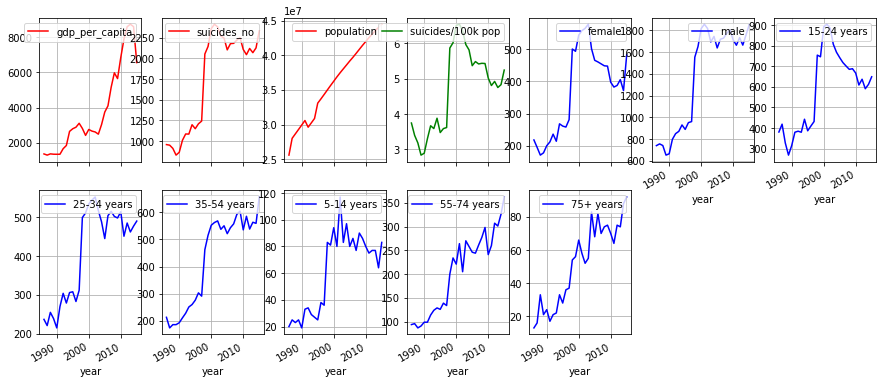

In [16]:
featuresCO=colombia_suicides
featuresCO.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

# Selección de tamaño de muestra de entrenamiento y validación

In [17]:
featuresCO=colombia_suicides
train_setCO=featuresCO.iloc[:25, :]
test_setCO=featuresCO.iloc[25:30,:]
test_setCO.shape

(5, 12)

# Estandarización de datos

In [18]:
TRAIN_SPLITCO=train_setCO.shape[0]
datasetCO = featuresCO.values
data_meanCO = datasetCO[:TRAIN_SPLITCO].mean(axis=0)
data_stdCO = datasetCO[:TRAIN_SPLITCO].std(axis=0)
datasetCO = (datasetCO-data_meanCO)/data_stdCO

# Selección de muestra de entrenamiento y validación

In [23]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleCO, y_train_singleCO = multivariate_data(datasetCO, datasetCO[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITCO, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleCO, y_val_singleCO = multivariate_data(datasetCO, datasetCO[:, 3],
                                               TRAIN_SPLITCO, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

# Convertir datos en tensores

In [24]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_singleCO = tf.data.Dataset.from_tensor_slices((x_train_singleCO, y_train_singleCO))
train_data_singleCO = train_data_singleCO.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleCO = tf.data.Dataset.from_tensor_slices((x_val_singleCO, y_val_singleCO))
val_data_singleCO = val_data_singleCO.batch(BATCH_SIZE).repeat()

## MODELO DE RED LSTM

In [26]:
single_step_modelCO = tf.keras.models.Sequential()
single_step_modelCO.add(tf.keras.layers.LSTM(60,input_shape=x_train_singleCO.shape[-2:]))
single_step_modelCO.add(tf.keras.layers.Dense(1))
single_step_modelCO.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_modelCO.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60)                17520     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 17,581
Trainable params: 17,581
Non-trainable params: 0
_________________________________________________________________


# Evaluación de función de pérdida

In [27]:
EPOCHS=30
EVALUATION_INTERVAL=1
single_step_historyCO = single_step_modelCO.fit(train_data_singleCO, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleCO,
                                            validation_steps=1)

Epoch 1/30
1/1 [==============================] - 0s 473ms/step - loss: 1.0160 - val_loss: 0.1800
Epoch 2/30
1/1 [==============================] - 0s 12ms/step - loss: 0.5825 - val_loss: 0.4882
Epoch 3/30
1/1 [==============================] - 0s 10ms/step - loss: 0.7423 - val_loss: 0.6189
Epoch 4/30
1/1 [==============================] - 0s 11ms/step - loss: 0.4822 - val_loss: 0.4550
Epoch 5/30
1/1 [==============================] - 0s 10ms/step - loss: 1.0057 - val_loss: 0.5418
Epoch 6/30
1/1 [==============================] - 0s 10ms/step - loss: 0.6493 - val_loss: 0.6229
Epoch 7/30
1/1 [==============================] - 0s 10ms/step - loss: 0.3262 - val_loss: 0.6014
Epoch 8/30
1/1 [==============================] - 0s 10ms/step - loss: 0.0828 - val_loss: 0.6939
Epoch 9/30
1/1 [==============================] - 0s 10ms/step - loss: 0.4840 - val_loss: 0.4941
Epoch 10/30
1/1 [==============================] - 0s 11ms/step - loss: 0.2887 - val_loss: 0.4117
Epoch 11/30
1/1 [===========

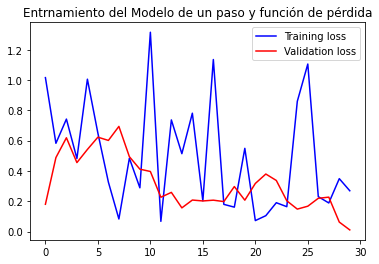

In [28]:
plot_train_history(single_step_historyCO,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

# Obtención de la predicción a un paso

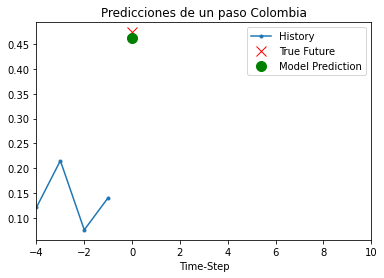

In [29]:
for x, y in val_data_singleCO.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelCO.predict(x)[0]], 0,
                   'Predicciones de un paso Colombia')
  plot.show()

# Graficar serie con dato predicho

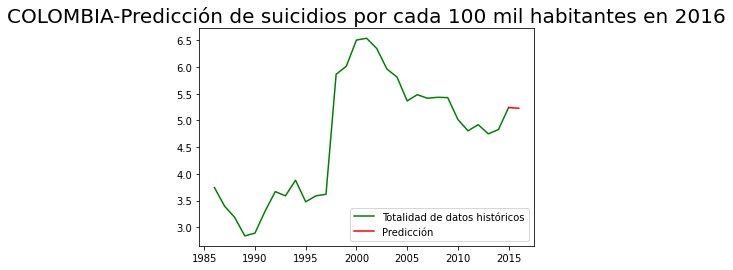

In [30]:
N=len(colombia_suicides.index)-1
new_index=np.append(colombia_suicides.index, colombia_suicides.index[N]+1)
new_pred=(single_step_modelCO.predict(x)[0])*data_stdCO[3]+data_meanCO[3]
new_suicides_rate=np.append(colombia_suicides['suicides/100k pop'],new_pred)
new_data=pd.DataFrame({'new_suicides_rate':new_suicides_rate},index=new_index)
plt.plot(new_data[:N+1], color='g', label='Totalidad de datos históricos')
plt.plot(new_data[N:],label='Predicción',color='r')
plt.title("COLOMBIA-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()

# MÉXICO

In [9]:
mexico_suicides=data[data.country=="Mexico"]
mexico_suicides=mexico_suicides.drop(['country'],axis='columns')
mexico_suicides=mexico_suicides.drop([1985],axis=0)
mexico_suicides.shape
mexico_suicides.head(5)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,1873,1714,69123500.0,2.479620,269,1445,525,458,412,57,188,74
1987,2064,1701,67948100.0,2.503381,285,1416,518,446,446,52,181,58
1988,2630,1703,69646000.0,2.445223,280,1423,536,420,413,61,206,67
1989,3125,1865,71359000.0,2.613546,285,1580,568,433,483,54,239,88
1990,3595,1926,73076900.0,2.635580,278,1648,586,444,495,51,258,92


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


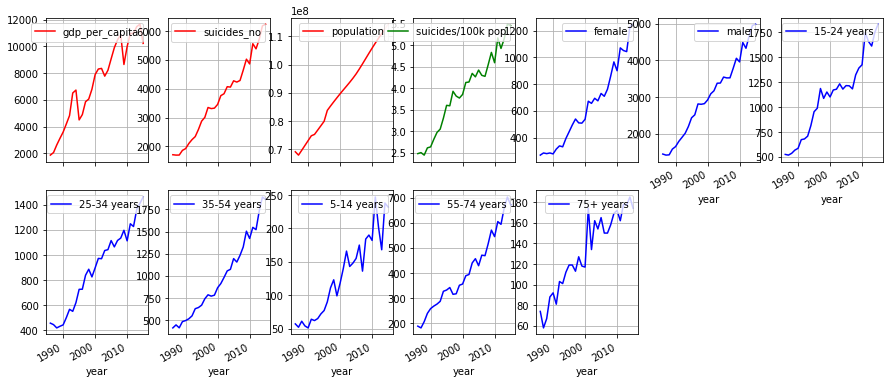

In [110]:
featuresME=mexico_suicides
featuresME.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

In [10]:
featuresME=mexico_suicides
train_setME=featuresME.iloc[:25, :]
test_setME=featuresME.iloc[25:30,:]

(5, 12)

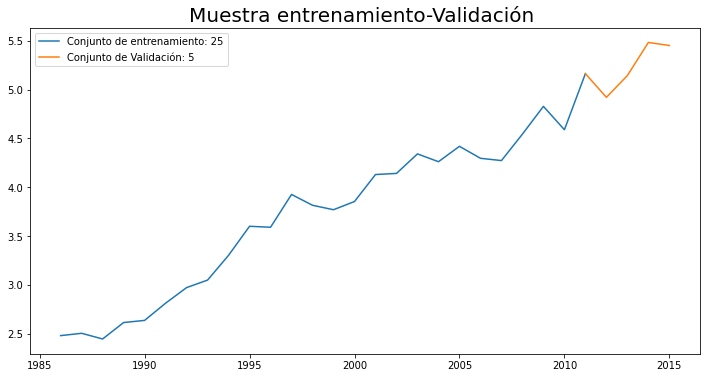

In [20]:
plt.figure(figsize=(12,6))
plt.plot(mexico_suicides['suicides/100k pop'][0:26], label='Conjunto de entrenamiento: 25' )
plt.plot(mexico_suicides['suicides/100k pop'][25:30], label='Conjunto de Validación: 5') 
plt.title("Muestra entrenamiento-Validación ", size = 20)
plt.legend()
plt.show()

In [112]:
TRAIN_SPLITME=train_setME.shape[0]
datasetME = featuresME.values
data_meanME = datasetME[:TRAIN_SPLITME].mean(axis=0)
data_stdME = datasetME[:TRAIN_SPLITME].std(axis=0)
datasetME = (datasetME-data_meanME)/data_stdME

In [113]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleME, y_train_singleME = multivariate_data(datasetME, datasetME[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITCH, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleME, y_val_singleME = multivariate_data(datasetME, datasetME[:, 3],
                                               TRAIN_SPLITME, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [114]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_singleME = tf.data.Dataset.from_tensor_slices((x_train_singleME, y_train_singleME))
train_data_singleME = train_data_singleME.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleME = tf.data.Dataset.from_tensor_slices((x_val_singleME, y_val_singleME))
val_data_singleME = val_data_singleME.batch(BATCH_SIZE).repeat()

In [115]:
single_step_modelME = tf.keras.models.Sequential()
single_step_modelME.add(tf.keras.layers.LSTM(70,input_shape=x_train_singleME.shape[-2:]))
single_step_modelME.add(tf.keras.layers.Dense(1))
single_step_modelME.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_modelME.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 70)                23240     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 71        
Total params: 23,311
Trainable params: 23,311
Non-trainable params: 0
_________________________________________________________________


In [116]:
EPOCHS=20
EVALUATION_INTERVAL=1
single_step_historyME = single_step_modelME.fit(train_data_singleME, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleME,
                                            validation_steps=1)

Epoch 1/20
1/1 [==============================] - 0s 383ms/step - loss: 0.5175 - val_loss: 2.3305
Epoch 2/20
1/1 [==============================] - 0s 13ms/step - loss: 1.2574 - val_loss: 1.5590
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7644 - val_loss: 1.1802
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4392 - val_loss: 0.9290
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4478 - val_loss: 0.6634
Epoch 6/20
1/1 [==============================] - 0s 9ms/step - loss: 0.3053 - val_loss: 1.0481
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3845 - val_loss: 0.5606
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3844 - val_loss: 0.5938
Epoch 9/20
1/1 [==============================] - 0s 9ms/step - loss: 0.5777 - val_loss: 0.6438
Epoch 10/20
1/1 [==============================] - 0s 9ms/step - loss: 0.2079 - val_loss: 0.6737
Epoch 11/20
1/1 [==============

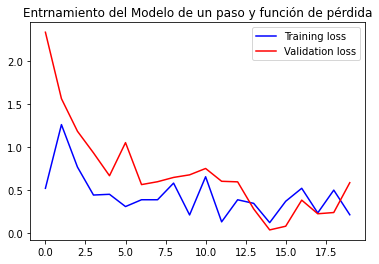

In [117]:
plot_train_history(single_step_historyME,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

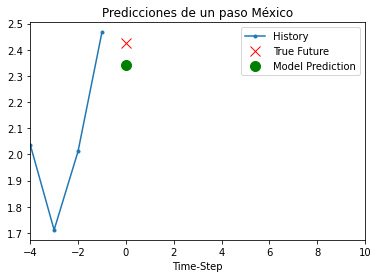

In [119]:
for x, y in val_data_singleME.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelME.predict(x)[0]], 0,
                   'Predicciones de un paso México')
  plot.show()

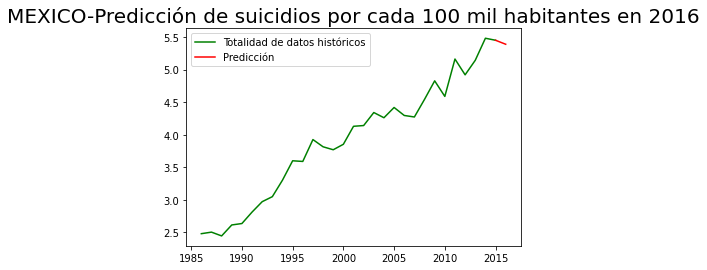

In [120]:
N=len(mexico_suicides.index)-1
new_index=np.append(mexico_suicides.index, mexico_suicides.index[N]+1)
new_pred=(single_step_modelME.predict(x)[0])*data_stdME[3]+data_meanME[3] #0.5
new_suicides_rate=np.append(mexico_suicides['suicides/100k pop'],new_pred)
new_data=pd.DataFrame({'new_suicides_rate':new_suicides_rate},index=new_index)
plt.plot(new_data[:N+1], color='g', label='Totalidad de datos históricos')
plt.plot(new_data[N:],label='Predicción',color='r')
plt.title("MEXICO-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()

In [ ]:
#calculo del error rms
import math
from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Resultado del test: %.2f RMSE' % (testScore))

# PUERTO RICO

In [430]:
puertor_suicides=data[data.country=="Puerto Rico"]
puertor_suicides=puertor_suicides.drop(['country'],axis='columns')
puertor_suicides=puertor_suicides.drop([1985],axis=0)
puertor_suicides.shape
puertor_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,7002,310,3143200.0,9.86256,38,272,21,68,110,1,71,39
1987,7533,272,3189400.0,8.52825,38,234,30,50,88,1,76,27


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


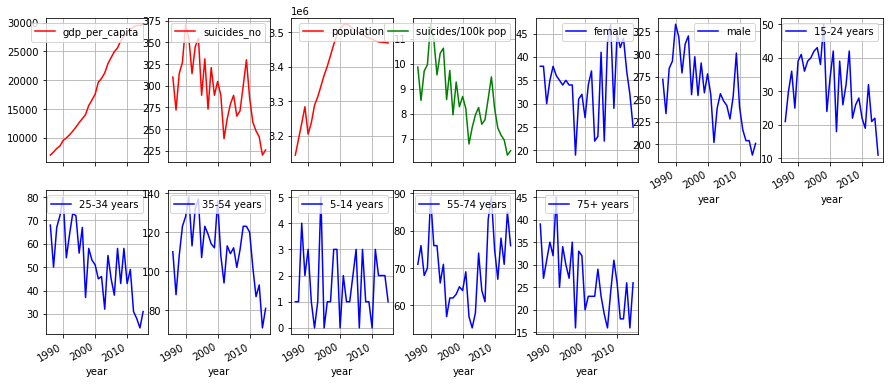

In [431]:
featuresPR=puertor_suicides
featuresPR.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

In [432]:
featuresPR=puertor_suicides
train_setPR=featuresPR.iloc[:25, :]
test_setPR=featuresPR.iloc[25:30,:]
test_setPR.shape

(5, 12)

In [433]:
TRAIN_SPLITPR=train_setPR.shape[0]
datasetPR = featuresPR.values
data_meanPR = datasetPR[:TRAIN_SPLITPR].mean(axis=0)
data_stdPR = datasetPR[:TRAIN_SPLITPR].std(axis=0)
datasetPR = (datasetPR-data_meanPR)/data_stdPR

In [434]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singlePR, y_train_singlePR = multivariate_data(datasetPR, datasetPR[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITPR, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singlePR, y_val_singlePR = multivariate_data(datasetPR, datasetPR[:, 3],
                                               TRAIN_SPLITPR, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [435]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_singlePR = tf.data.Dataset.from_tensor_slices((x_train_singlePR, y_train_singlePR))
train_data_singlePR = train_data_singlePR.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singlePR = tf.data.Dataset.from_tensor_slices((x_val_singlePR, y_val_singlePR))
val_data_singlePR = val_data_singlePR.batch(BATCH_SIZE).repeat()

In [436]:
single_step_modelPR = tf.keras.models.Sequential()
single_step_modelPR.add(tf.keras.layers.LSTM(60,input_shape=x_train_singlePR.shape[-2:]))
single_step_modelPR.add(tf.keras.layers.Dense(1))
single_step_modelPR.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_modelPR.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 60)                17520     
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 61        
Total params: 17,581
Trainable params: 17,581
Non-trainable params: 0
_________________________________________________________________


In [437]:
EPOCHS=30
EVALUATION_INTERVAL=1
single_step_historyPR = single_step_modelPR.fit(train_data_singlePR, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singlePR,
                                            validation_steps=1)

Epoch 1/30
1/1 [==============================] - 0s 384ms/step - loss: 0.5706 - val_loss: 1.7972
Epoch 2/30
1/1 [==============================] - 0s 12ms/step - loss: 0.7760 - val_loss: 1.3863
Epoch 3/30
1/1 [==============================] - 0s 11ms/step - loss: 0.9356 - val_loss: 1.3540
Epoch 4/30
1/1 [==============================] - 0s 10ms/step - loss: 1.5942 - val_loss: 1.4064
Epoch 5/30
1/1 [==============================] - 0s 12ms/step - loss: 0.7106 - val_loss: 1.3040
Epoch 6/30
1/1 [==============================] - 0s 11ms/step - loss: 0.9246 - val_loss: 1.2003
Epoch 7/30
1/1 [==============================] - 0s 12ms/step - loss: 0.2320 - val_loss: 0.9695
Epoch 8/30
1/1 [==============================] - 0s 10ms/step - loss: 0.6859 - val_loss: 1.0392
Epoch 9/30
1/1 [==============================] - 0s 10ms/step - loss: 0.3997 - val_loss: 0.8707
Epoch 10/30
1/1 [==============================] - 0s 10ms/step - loss: 0.1532 - val_loss: 0.7028
Epoch 11/30
1/1 [===========

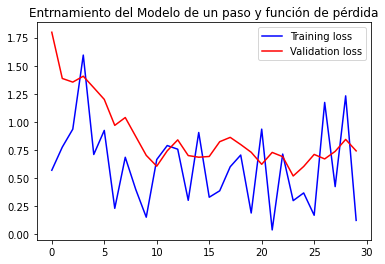

In [438]:
plot_train_history(single_step_historyPR,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

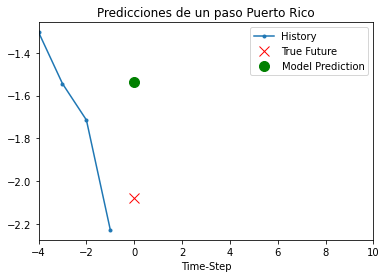

In [441]:
for x, y in val_data_singlePR.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelPR.predict(x)[0]], 0,
                   'Predicciones de un paso Puerto Rico')
  plot.show()

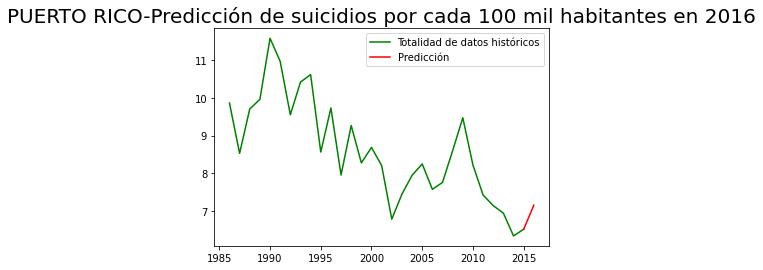

In [442]:
N=len(puertor_suicides.index)-1
new_index=np.append(puertor_suicides.index, puertor_suicides.index[N]+1)
new_pred=(single_step_modelPR.predict(x)[0])*data_stdPR[3]+data_meanPR[3] #0.2
new_suicides_rate=np.append(puertor_suicides['suicides/100k pop'],new_pred)
new_data=pd.DataFrame({'new_suicides_rate':new_suicides_rate},index=new_index)
plt.plot(new_data[:N+1], color='g', label='Totalidad de datos históricos')
plt.plot(new_data[N:],label='Predicción',color='r')
plt.title("PUERTO RICO-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()

# ESPAÑA

In [592]:
españa_suicides=data[data.country=="Spain"]
españa_suicides=españa_suicides.drop(['country'],axis='columns')
españa_suicides=españa_suicides.drop([1985],axis=0)
españa_suicides.shape
españa_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,6919,2755,36223000.0,7.605665,723,2032,281,340,695,29,978,432
1987,8727,2804,36425700.0,7.697862,787,2017,284,367,659,19,1013,462


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


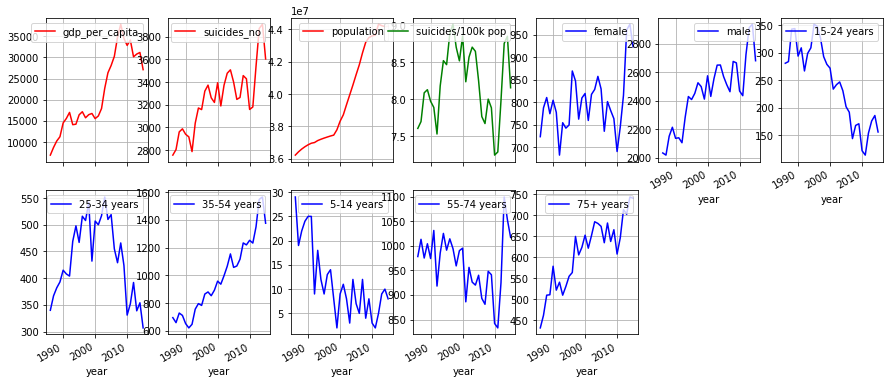

In [593]:
featuresES=españa_suicides
featuresES.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

In [709]:
featuresES=españa_suicides
train_setES=featuresES.iloc[:25, :]
test_setES=featuresES.iloc[25:30,:]
test_setES.shape

(10, 12)

In [710]:
TRAIN_SPLITES=train_setES.shape[0]
datasetES = featuresES.values
data_meanES = datasetES[:TRAIN_SPLITES].mean(axis=0)
data_stdES = datasetES[:TRAIN_SPLITES].std(axis=0)
datasetES = (datasetES-data_meanES)/data_stdES

In [772]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleES, y_train_singleES = multivariate_data(datasetES, datasetES[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITES, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleES, y_val_singleES = multivariate_data(datasetES, datasetES[:, 3],
                                               TRAIN_SPLITES, None, past_history,
                                               future_target, STEP,
                                               single_step=True)


In [773]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_singleES = tf.data.Dataset.from_tensor_slices((x_train_singleES, y_train_singleES))
train_data_singleES = train_data_singleES.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleES = tf.data.Dataset.from_tensor_slices((x_val_singleES, y_val_singleES))
val_data_singleES = val_data_singleES.batch(BATCH_SIZE).repeat()

In [774]:
single_step_modelES = tf.keras.models.Sequential()
single_step_modelES.add(tf.keras.layers.LSTM(30,input_shape=x_train_singleES.shape[-2:]))
single_step_modelES.add(tf.keras.layers.Dense(1))
single_step_modelES.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_modelES.summary()

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_92 (LSTM)               (None, 30)                5160      
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 31        
Total params: 5,191
Trainable params: 5,191
Non-trainable params: 0
_________________________________________________________________


In [775]:
EPOCHS=100
EVALUATION_INTERVAL=1
single_step_historyES = single_step_modelES.fit(train_data_singleES, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleES,
                                            validation_steps=1)

Epoch 1/100
1/1 [==============================] - 0s 363ms/step - loss: 0.6610 - val_loss: 1.5882
Epoch 2/100
1/1 [==============================] - 0s 10ms/step - loss: 0.7928 - val_loss: 1.3879
Epoch 3/100
1/1 [==============================] - 0s 8ms/step - loss: 0.9303 - val_loss: 1.4353
Epoch 4/100
1/1 [==============================] - 0s 8ms/step - loss: 0.9034 - val_loss: 1.3872
Epoch 5/100
1/1 [==============================] - 0s 8ms/step - loss: 0.6535 - val_loss: 1.3355
Epoch 6/100
1/1 [==============================] - 0s 8ms/step - loss: 0.7674 - val_loss: 1.4214
Epoch 7/100
1/1 [==============================] - 0s 8ms/step - loss: 0.7209 - val_loss: 1.4329
Epoch 8/100
1/1 [==============================] - 0s 8ms/step - loss: 0.5605 - val_loss: 1.2657
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 0.8004 - val_loss: 1.2335
Epoch 10/100
1/1 [==============================] - 0s 7ms/step - loss: 0.3946 - val_loss: 1.1252
Epoch 11/100
1/1 [========

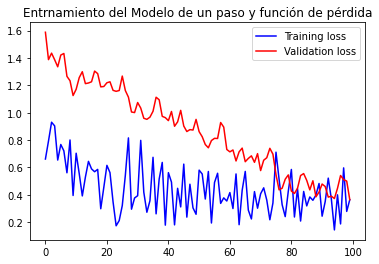

In [776]:
plot_train_history(single_step_historyES,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

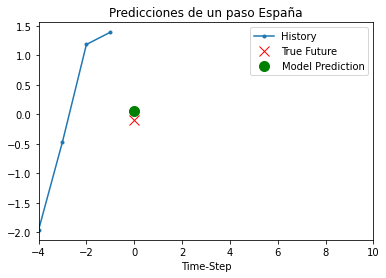

In [563]:
for x, y in val_data_singleES.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelES.predict(x)[0]], 0,
                   'Predicciones de un paso España')
  plot.show()

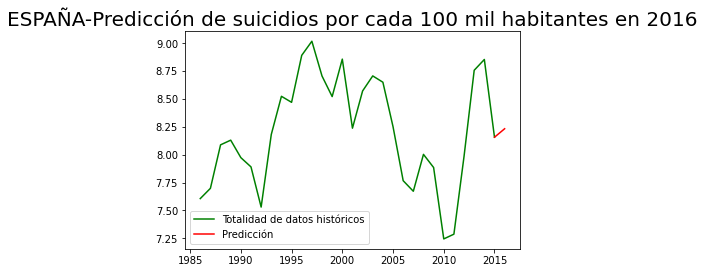

In [564]:
N=len(españa_suicides.index)-1
new_index=np.append(españa_suicides.index, españa_suicides.index[N]+1)
new_pred=(single_step_modelES.predict(x)[0])*data_stdES[3]+data_meanES[3]
new_suicides_rate=np.append(españa_suicides['suicides/100k pop'],new_pred)
new_data=pd.DataFrame({'new_suicides_rate':new_suicides_rate},index=new_index)
plt.plot(new_data[:N+1], color='g', label='Totalidad de datos históricos')
plt.plot(new_data[N:],label='Predicción',color='r')
plt.title("ESPAÑA-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()

# ARGENTINA

In [944]:
argentina_suicides=data[data.country=="Argentina"]
argentina_suicides=argentina_suicides.drop(['country'],axis='columns')
argentina_suicides=argentina_suicides.drop([1985],axis=0)
argentina_suicides.shape
argentina_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,4072,2284,27244400.0,8.383374,641,1643,287,305,666,17,731,278
1987,4026,2286,27599400.0,8.282789,686,1600,272,281,691,29,756,257


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


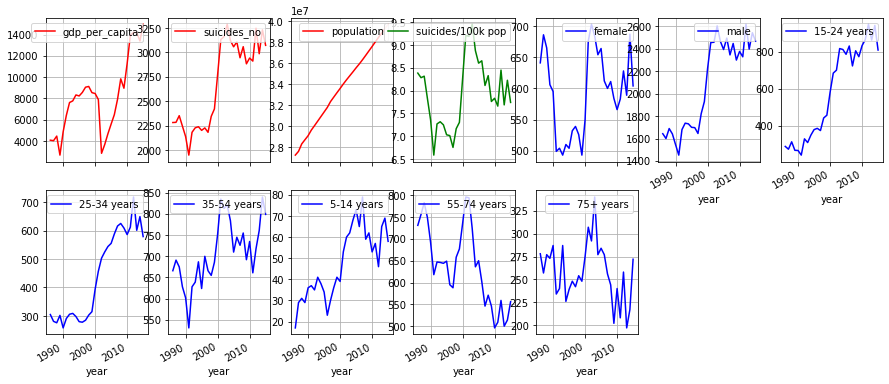

In [945]:
featuresAR=argentina_suicides
featuresAR.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

In [946]:
featuresAR=argentina_suicides
train_setAR=featuresAR.iloc[:25, :]
test_setAR=featuresAR.iloc[25:30,:]
test_setAR.shape

(5, 12)

In [947]:
TRAIN_SPLITAR=train_setAR.shape[0]
datasetAR = featuresAR.values
data_meanAR = datasetAR[:TRAIN_SPLITAR].mean(axis=0)
data_stdAR = datasetAR[:TRAIN_SPLITAR].std(axis=0)
datasetAR = (datasetAR-data_meanAR)/data_stdAR

In [948]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleAR, y_train_singleAR = multivariate_data(datasetAR, datasetAR[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITAR, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleAR, y_val_singleAR = multivariate_data(datasetAR, datasetAR[:, 3],
                                               TRAIN_SPLITAR, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [949]:
BATCH_SIZE=3
BUFFER_SIZE=1000

train_data_singleAR = tf.data.Dataset.from_tensor_slices((x_train_singleAR, y_train_singleAR))
train_data_singleAR = train_data_singleAR.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleAR = tf.data.Dataset.from_tensor_slices((x_val_singleAR, y_val_singleAR))
val_data_singleAR = val_data_singleAR.batch(BATCH_SIZE).repeat()

In [950]:
single_step_modelAR = tf.keras.models.Sequential()
single_step_modelAR.add(tf.keras.layers.LSTM(100,input_shape=x_train_singleAR.shape[-2:]))
single_step_modelAR.add(tf.keras.layers.Dense(1))
single_step_modelAR.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_modelAR.summary()

Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_112 (LSTM)              (None, 100)               45200     
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 101       
Total params: 45,301
Trainable params: 45,301
Non-trainable params: 0
_________________________________________________________________


In [951]:
EPOCHS=15
EVALUATION_INTERVAL=1
single_step_historyAR = single_step_modelAR.fit(train_data_singleAR, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleAR,
                                            validation_steps=1)

Epoch 1/15
1/1 [==============================] - 0s 370ms/step - loss: 0.5086 - val_loss: 0.5469
Epoch 2/15
1/1 [==============================] - 0s 8ms/step - loss: 0.8410 - val_loss: 0.5657
Epoch 3/15
1/1 [==============================] - 0s 8ms/step - loss: 1.2261 - val_loss: 0.6319
Epoch 4/15
1/1 [==============================] - 0s 8ms/step - loss: 0.9718 - val_loss: 0.2756
Epoch 5/15
1/1 [==============================] - 0s 9ms/step - loss: 0.6057 - val_loss: 0.4493
Epoch 6/15
1/1 [==============================] - 0s 10ms/step - loss: 0.3918 - val_loss: 0.3772
Epoch 7/15
1/1 [==============================] - 0s 8ms/step - loss: 0.3382 - val_loss: 0.4062
Epoch 8/15
1/1 [==============================] - 0s 8ms/step - loss: 0.7417 - val_loss: 0.4551
Epoch 9/15
1/1 [==============================] - 0s 9ms/step - loss: 0.3932 - val_loss: 0.4043
Epoch 10/15
1/1 [==============================] - 0s 8ms/step - loss: 0.4098 - val_loss: 0.1023
Epoch 11/15
1/1 [===================

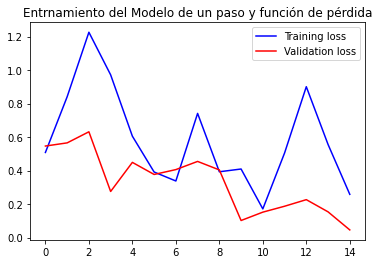

In [952]:
plot_train_history(single_step_historyAR,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

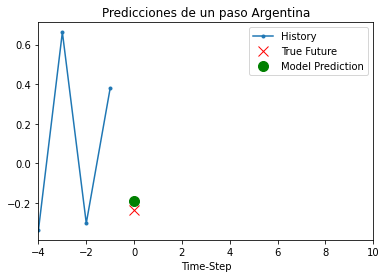

In [953]:
for x, y in val_data_singleAR.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelAR.predict(x)[0]], 0,
                   'Predicciones de un paso Argentina')
  plot.show()

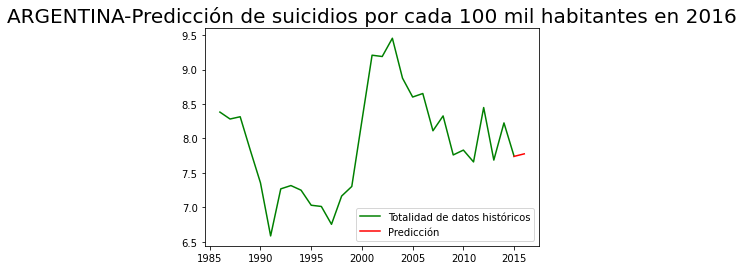

In [954]:
N=len(argentina_suicides.index)-1
new_index=np.append(argentina_suicides.index, argentina_suicides.index[N]+1)
new_pred=(single_step_modelAR.predict(x)[0])*data_stdAR[3]+data_meanAR[3]
new_suicides_rate=np.append(argentina_suicides['suicides/100k pop'],new_pred)
new_data=pd.DataFrame({'new_suicides_rate':new_suicides_rate},index=new_index)
plt.plot(new_data[:N+1], color='g', label='Totalidad de datos históricos')
plt.plot(new_data[N:],label='Predicción',color='r')
plt.title("ARGENTINA-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()